<hr style="height: 4px; color: #839D2D; width: 100%; ">

# <font color='#61210B'>Formation OpenClassRooms   -   Parcours DATA ANALYST</font>

<hr style="height: 2px; color: #839D2D; width: 100%; ">

## <font color='#38610B'>Projet VII - Prédictions de Revenus</font>



### Mission 1 - Data Import/Cleaning - Analyse Descriptive
### Mission 2 - Etude des Coefficients Gini - Courbes de Lorenz



###  

<u>Les données sont issues de</u> :
- Openclassrooms - (<a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/data-projet7.csv">Data world income distribution</a>)  
- Openclassrooms (<a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/projet_7.zip">Coefficients d'elasticité</a>)  
- Banque Mondiale - World Bank Open Data (<a href="http://data.worldbank.org/indicator/SI.POV.GINI">Indices de Gini</a>)  
- Banque Mondiale - World Bank Open Data (<a href="http://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim">Coefficients d'elasticité</a>)  
- Wikipedia (données ISO-3166 Codes pays)

<u>DataFrames pandas utilisés et critères de téléchargement</u> :  
* <font color='#8A0808'>DataFrame <strong>wid</strong></font> : Distributions de revenus par année/pays/classe en gdp_$ppp  
1ère mise en forme avec Excel.

* <font color='#8A0808'>DataFrame <strong>gini</strong></font> : Indices de Gini et "income group" par année/pays
* <font color='#8A0808'>DataFrame <strong>pop</strong></font> : Population par année/pays 
* <font color='#013ADF'>DataFrame <strong>gen</strong></font> : Fichier enrichi, nettoyé avec datas de wid, gini & pop
* <font color='#8A0808'>DataFrame <strong>gdim</strong></font> : Coefficients d'élasticité


  
**<font color='#38610B'>- Date : 5 Aout 2019</font>**  
Auteur : Frédéric Boissy
<hr style="height: 4px; color: #839D2D; width: 100%; ">


#### Initialisation (Libraries - Functions - etc...)

In [1]:
import time
start_time = time.time()

# -*- coding: utf8 -*-
from init_libraries import *
# /////  Pour executer des requetes SQL de verification sur des DF  /////
from pandasql            import sqldf
execsql = lambda q: sqldf(q, globals())   

# Limiter le nombre de lignes d'affichage des Dataframes
pd.options.display.max_rows=20

# %matplotlib notebook   (a placer dans deux cellules différentes et permet d'avoir une interaction sur des graphes 2D/3D)

#### DEBUGGER python
Ajout de ligne BKP avec commande breakpoint() à l'endroit désiré.  
* Actions autorisées : c/n/s/q
    * c - continue execution
    * n - step to the next line within the same function
    * s - step to the next line in this function or a called function
    * q - quit the debugger/execution


In [2]:
import pdb
# breakpoint()

<hr style="height: 3px; color: #839D2D; width: 100%; ">

##  <font color='#61210B'><u>M1 - Data Import/Cleaning - Analyse Descriptive</u></font>



<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Données "World Inconme Distribution" : Dataframe "wid"</font>

In [3]:
wid = pd.read_csv("DATA/data-projet7.csv")
# Remplacer la "," par un "." avant de convertir 
wid['income']   = wid['income'].str.replace(',','.')
wid['income']   = wid['income'].astype(float)
wid['gdpppp']   = wid['gdpppp'].str.replace(',','.')
wid['gdpppp']   = wid['gdpppp'].astype(float)

# supprimer la colonne nb_quantiles
wid.drop(columns=['nb_quantiles'], inplace=True)

# renommer la colonne year_survey en year
wid.rename(columns={'year_survey':'year'}, inplace=True)

# Remplacer les éventuelles valeurs Nan par des 0
wid.fillna(0)

wid.info()
print(wid.shape)
wid.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 5 columns):
country     11599 non-null object
year        11599 non-null int64
quantile    11599 non-null int64
income      11599 non-null float64
gdpppp      11399 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 453.2+ KB
(11599, 5)


,country,year,quantile,income,gdpppp
count,11599,"11,599.000","11,599.000","11,599.000","11,399.000"
unique,116,nan,nan,nan,nan
top,ESP,nan,nan,nan,nan
freq,100,nan,nan,nan,nan
mean,NaN,"2,007.983",50.501,"6,069.224","50,221.278"
std,NaN,0.910,28.868,"9,414.186","400,068.751"
min,NaN,"2,004.000",1.000,16.719,303.193
25%,NaN,"2,008.000",25.500,900.686,"2,576.000"
50%,NaN,"2,008.000",51.000,"2,403.245","7,560.000"
75%,NaN,"2,008.000",75.500,"7,515.421","18,773.000"


Ici 1er constat ecart de 200 entre gdpppp et income...  
Egalement une très grosse valeur de gdpppp à vérifier...  
Comptons le nombre chaque colonne/variable par année.  
On part du postulat que sont définis 100 centiles par année

In [4]:
# wid.groupby("year").count()/100
req1 = ''' 
Select year, count(quantile) as "Nb_Quantiles", count(country)/100 as "Nb_Pays", count(income)/100, count(gdpppp)/100
From wid
Group By year
'''
df1 = execsql(req1)
df1

,year,Nb_Quantiles,Nb_Pays,count(income)/100,count(gdpppp)/100
0,2004,100,1,1,1
1,2006,500,5,5,5
2,2007,1500,15,15,15
3,2008,7599,75,75,74
4,2009,1200,12,12,11
5,2010,600,6,6,6
6,2011,100,1,1,1


Constat Année 2008 :  Nombre de quantiles n'est pas un multiple de 100 sur l'année 2008.  
Recherche des pays ayant un nombre de quantiles annuel <> 100  
De plus certains données manquantes en terme de gdpppp sur 2008 et  2009

In [5]:
req1 = ''' 
Select country, year, count(quantile) as "Nb_Quantiles", count(country)/100 as "Nb_Pays"
From wid
Group By country, year
Having count(*) <> 100
'''
df1 = execsql(req1)
df1.head()

,country,year,Nb_Quantiles,Nb_Pays
0,LTU,2008,99,0


In [6]:
wid.groupby(['country']).count()[wid.groupby(['country']).count().values!=100]

,year,quantile,income,gdpppp
country,,,,
LTU,99,99,99,99
LTU,99,99,99,99
LTU,99,99,99,99
LTU,99,99,99,99
PSE,100,100,100,0
XKX,100,100,100,0


In [7]:
wid[(wid.year == 2008) & (wid.country == "LTU") & (wid['quantile'] >= 38) & (wid['quantile'] <= 42)]

,country,year,quantile,income,gdpppp
6237,LTU,2008,38,"4,756.434","17,571.000"
6238,LTU,2008,39,"4,802.368","17,571.000"
6239,LTU,2008,40,"4,868.451","17,571.000"
6240,LTU,2008,42,"4,895.831","17,571.000"


<font color='blue'><i><b>Il manque la classe de revenu du quantile 41 pour l'année 2008 et pour la Lituanie.</i></b></font>  

    ° Creation d'une ligne pour ce quantile manquant en prenant la valeur intermédiaire entre les quantiles 40 & 42

In [8]:
calc_revenu_LTU_41 = wid.loc[6239].income + (wid.loc[6240].income - wid.loc[6239].income)/2
LTU_line_quant_41 = pd.DataFrame({"country":"LTU", "year":2008, "quantile":41, 
                                 "income":calc_revenu_LTU_41, "gdpppp":17571}, index=[6240])
LTU_line_quant_41

,country,year,quantile,income,gdpppp
6240,LTU,2008,41,"4,882.141",17571


In [9]:
# Suppression de la ligne 41 pour ne pas créer de doublons si on execute plusieurs fois cette cellule
wid = wid.drop(wid[(wid['country'] == 'LTU') & (wid['year'] == 2008) & (wid['quantile'] == 41)].index)
wid = pd.concat([wid.loc[:6239], LTU_line_quant_41, wid.loc[6240:]]).reset_index(drop=True)
wid.info()
wid[(wid.year == 2008) & (wid.country == "LTU") & (wid['quantile'] >= 39) & (wid['quantile'] <= 42)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 5 columns):
country     11600 non-null object
year        11600 non-null int64
quantile    11600 non-null int64
income      11600 non-null float64
gdpppp      11400 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 453.2+ KB


,country,year,quantile,income,gdpppp
6238,LTU,2008,39,"4,802.368","17,571.000"
6239,LTU,2008,40,"4,868.451","17,571.000"
6240,LTU,2008,41,"4,882.141","17,571.000"
6241,LTU,2008,42,"4,895.831","17,571.000"


<font color='blue'><i><b>Manquent aussi les données gdpppp pour la Palestine (PSE) et le Kosovo (XKX).</i></b></font>  
Imputation des valeurs d'après les sources  :
- (<a href="https://www.theglobaleconomy.com/Palestine/GDP_per_capita_PPP/">PSE</a>)  gdpppp Palestine = 3612.14
- (<a href="https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2009&locations=XK&start=2007&view=chart">XKX</a>)  gdpppp Kosovo = 7236.41

In [10]:
# Palestine (PSE)
wid.loc[wid["country"] == 'PSE', "gdpppp"] = 3612.14
# Kosovo (XKX)
wid.loc[wid["country"] == 'XKX', "gdpppp"] = 7236.41

<font color='blue'><i><b>Valeur énorme en gdpppp FIDJI</i></b></font>  
Modification de la valeur d'après la source  :
- (<a href="https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD?end=2009&locations=FJ&start=2007">XKX</a>)  gdpppp Fidji = 7078.62

In [11]:
wid[(wid['country'] == 'FJI')].head()

,country,year,quantile,income,gdpppp
3200,FJI,2008,1,308.173,"4,300,332.000"
3201,FJI,2008,2,384.332,"4,300,332.000"
3202,FJI,2008,3,436.593,"4,300,332.000"
3203,FJI,2008,4,486.814,"4,300,332.000"
3204,FJI,2008,5,520.197,"4,300,332.000"


In [12]:
# Iles Fidji (FJI)
wid.loc[wid["country"] == 'FJI', "gdpppp"] = 7078.62
wid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 5 columns):
country     11600 non-null object
year        11600 non-null int64
quantile    11600 non-null int64
income      11600 non-null float64
gdpppp      11600 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 453.2+ KB


<font color='blue'><i><b>Répartition des Pays par Année</i></b></font>  

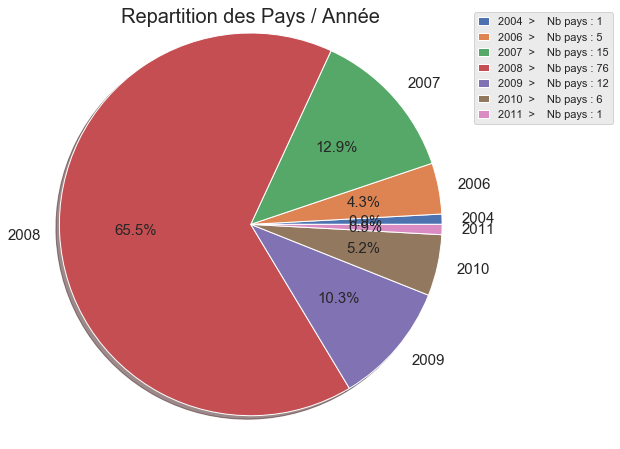

In [13]:
plt.rcParams['legend.handlelength'] = 1  #  Permet d'ajouter le trait de couleur dans la légende
# Pie chart
try:
    vals = wid.groupby("year").count()["country"].values
    libelles = np.sort(wid["year"].unique())
except KeyError:
    print()

i = 0
txtlgd = [""] * len(vals)
for i in range(len(vals)):
    txtlgd[i] = str(libelles[i]) + "  >    Nb pays : " + str(int(vals[i]/100))
#     print(txtlgd)
    i = i+1
len(vals)        

fig = plt.figure(figsize=(8,8))
ax = plt.pie(vals, labels=libelles, autopct='%0.1f%%', radius=1.1, startangle=0, 
        textprops={'fontsize': 15}, shadow=True)
        # shadow=True, explode=[0.5,0.1,0.1,0,0.1,0.1,0.5]
plt.title("Repartition des Pays / Année", fontsize=20, y=0.95)
plt.legend(txtlgd, loc="best", bbox_to_anchor=(1, 1), facecolor="#E6E6E6")

plt.savefig('OUTFILES/M1-Repartition_Pays_annee_wid.png', dpi=100, bbox_inches='tight')



plt.show()
plt.close()

In [14]:
wid[(wid.year == 2004) | (wid.year == 2011)].groupby('year')[['country']].nunique()
req1 = ''' 
Select year, country, count(country)/100 as "Nb_Pays"
From wid
Group By year, country
Having year in (2004, 2011)
'''
df1 = execsql(req1)
df1

,year,country,Nb_Pays
0,2004,SYR,1
1,2011,GTM,1


In [15]:
# Renommer certaines colonnes
wid.rename(columns={'country':'country_code'},inplace=True)
wid = wid.set_index(['country_code', 'year']).dropna(how="all")
wid.head()

quantile    income    gdpppp
country_code year                              
ALB          2008         1   728.898 7,297.000
             2008         2   916.662 7,297.000
             2008         3 1,010.916 7,297.000
             2008         4 1,086.908 7,297.000
             2008         5 1,132.700 7,297.000

In [16]:
wid.info()
wid.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11600 entries, (ALB, 2008) to (COD, 2008)
Data columns (total 3 columns):
quantile    11600 non-null int64
income      11600 non-null float64
gdpppp      11600 non-null float64
dtypes: float64(2), int64(1)
memory usage: 295.6+ KB


,quantile,income,gdpppp
count,"11,600.000","11,600.000","11,600.000"
mean,50.500,"6,069.122","12,435.296"
std,28.867,"9,413.787","13,097.663"
min,1.000,16.719,303.193
25%,25.750,900.769,"2,577.500"
50%,50.500,"2,403.493","7,488.500"
75%,75.250,"7,515.314","17,679.250"
max,100.000,"176,928.550","73,127.000"


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Données "indices de Gini" de la Banque Mondiale : Dataframe "gini"</font>

In [17]:
# gini = pd.read_excel("DATA/data_gini.xlsx", sheet_name='data') 
gini = pd.read_excel("DATA/gini.xlsm", sheet_name='gini_lin') 

# Suppression des lignes Nan
gini.dropna(inplace=True)

# Afficher description fichier
gini.info()
print(gini.shape)
gini.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486 entries, 101 to 10512
Data columns (total 5 columns):
country_code    1486 non-null object
country_name    1486 non-null object
incomegroup     1486 non-null object
year            1486 non-null int64
gini            1486 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 69.7+ KB
(1486, 5)


,country_code,country_name,incomegroup,year,gini
count,1486,1486,1486,"1,486.000","1,486.000"
unique,164,164,4,nan,nan
top,BRA,Brazil,Upper middle,nan,nan
freq,33,33,551,nan,nan
mean,NaN,NaN,NaN,"2,005.193",39.157
std,NaN,NaN,NaN,8.089,9.423
min,NaN,NaN,NaN,"1,979.000",21.000
25%,NaN,NaN,NaN,"2,001.000",31.800
50%,NaN,NaN,NaN,"2,007.000",37.100
75%,NaN,NaN,NaN,"2,011.000",46.075


In [18]:
gini.set_index(['country_code', 'year']).head(15)

country_name   incomegroup   gini
country_code year                                  
AGO          2000       Angola  Lower middle 52.000
             2008       Angola  Lower middle 42.700
ALB          1996      Albania  Upper middle 27.000
             2002      Albania  Upper middle 31.700
             2005      Albania  Upper middle 30.600
             2008      Albania  Upper middle 30.000
             2012      Albania  Upper middle 29.000
ARG          1980    Argentina  Upper middle 40.800
             1986    Argentina  Upper middle 42.800
             1987    Argentina  Upper middle 45.300
             1991    Argentina  Upper middle 46.800
             1992    Argentina  Upper middle 45.500
             1993    Argentina  Upper middle 44.900
             1994    Argentina  Upper middle 45.900
             1995    Argentina  Upper middle 48.900

<font color='blue'><i><b>Constitution d'un dataframe de l'évolution des indices de Gini</i></b></font>  
Sur la période de notre périmètre (2004 à 2011)
- <b>NE</b> conserver que les données existant dans le <b>dataframe "wid" : Clef --> country_code</b>  
- <b>Pivoter</b> les données annuelles en colonnes

In [19]:
dfgin = pd.merge(gini, wid[[]], on=['country_code'], how='inner').drop_duplicates()
dfgin = dfgin[(dfgin['year'] >= 2004) & (dfgin['year'] <= 2011)]
# Liste des années distinctes afin de crééer les noms de colonnes pertinents
np.sort(dfgin["year"].unique())

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011], dtype=int64)

In [20]:
gini_evo = dfgin.pivot_table(
    index=["country_code"], columns=['year'], values = ["gini"], aggfunc='mean')
gini_evo.columns = ['gini04', 'gini05', 'gini06', 'gini07', 'gini08', 'gini09', 'gini10', 'gini11']
gini_evo

,gini04,gini05,gini06,gini07,gini08,gini09,gini10,gini11
country_code,,,,,,,,
ALB,nan,30.600,nan,nan,30.000,nan,nan,nan
ARG,48.300,47.700,46.600,46.300,44.500,43.900,43.000,42.300
ARM,37.500,36.000,29.700,31.200,29.200,28.000,30.000,29.400
AUT,29.800,28.700,29.600,30.600,30.400,31.500,30.300,30.800
AZE,26.600,26.600,nan,nan,nan,nan,nan,nan
BEL,30.500,29.300,28.100,29.200,28.400,28.500,28.400,28.100
BFA,nan,nan,nan,nan,nan,39.800,nan,nan
BGD,nan,33.200,nan,nan,nan,nan,32.100,nan
BGR,nan,nan,35.700,36.100,33.600,33.800,35.700,34.300


<font color='blue'><i><b>Constitution d'un dataframe Gini avec la moyenne des indices/ pays pour 2004 à 2011</i></b></font>  

Prendre la valeur moyenne de l'indice de gini sur cette tranche d'années

In [21]:
gini_moy = gini[(gini['year'] >= 2004) & (gini['year'] <= 2011)].groupby(['country_code', 'country_name']).mean()[['gini']].reset_index()
gini_moy

,country_code,country_name,gini
0,AGO,Angola,42.700
1,ALB,Albania,30.300
2,ARG,Argentina,45.325
3,ARM,Armenia,31.375
4,AUS,Australia,34.400
5,AUT,Austria,30.213
6,AZE,Azerbaijan,26.600
7,BDI,Burundi,33.400
8,BEL,Belgium,28.812
9,BEN,Benin,43.400


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Données "population" de la Banque Mondiale : Dataframe "pop"</font>

In [22]:
# pop = pd.read_excel("DATA/data_pop.xlsx", sheet_name='data') 
pop  = pd.read_excel("DATA/pop.xlsm", sheet_name='pop_lin')
# Remplacer les éventuelles valeurs Nan par des 0
pop.fillna(0)
# Afficher description fichier
pop.info()
print(pop.shape)
pop.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15517 entries, 0 to 15516
Data columns (total 4 columns):
country_code    15517 non-null object
country_name    15517 non-null object
year            15517 non-null int64
population      15409 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 485.0+ KB
(15517, 4)


,country_code,country_name,year,population
count,15517,15517,"15,517.000","15,409.000"
unique,263,263,nan,nan
top,MNP,Liberia,nan,nan
freq,59,59,nan,nan
mean,NaN,NaN,"1,989.000","207,886,506.566"
std,NaN,NaN,17.030,"686,779,636.782"
min,NaN,NaN,"1,960.000","3,893.000"
25%,NaN,NaN,"1,974.000","926,841.000"
50%,NaN,NaN,"1,989.000","6,418,773.000"
75%,NaN,NaN,"2,004.000","42,449,038.000"


In [23]:
pop.set_index(['country_code', 'country_name', 'year']).head(10)

population
country_code country_name year            
ABW          Aruba        1960  54,211.000
                          1961  55,438.000
                          1962  56,225.000
                          1963  56,695.000
                          1964  57,032.000
                          1965  57,360.000
                          1966  57,715.000
                          1967  58,055.000
                          1968  58,386.000
                          1969  58,726.000

<b> Remarque : </b>  Taiwan (TWN) n'a pas été trouvé dans le dataframe population.

In [24]:
req1 = ''' 
Select distinct country_code From wid
Where  country_code not in (select country_code from pop where year = 2008)
'''
df1 = execsql(req1)
df1

,country_code
0,TWN


<b> Remarque : </b>  Taiwan (TWN) et le Cambodge (KHM) n'ont pas été trouvés dans le dataframe des indices de gini moyen entre 2004 & 2011.

In [25]:
req1 = ''' 
Select distinct country_code From wid
Where  country_code not in (select country_code from gini_moy)
'''
df1 = execsql(req1)
df1

,country_code
0,KHM
1,TWN


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue">Fusion des 3 dataframes (wid, gini, pop) -->  Dataframe "gen"</font>

- Avec Dataframe wid maitre et recupération de la "population" en égalité sur la Key=(country/year) et des infos "gini_moy" en égalité sur la Key=(country)

        Equivalence Requete SQL:
        Select * 
        From wid w Inner Join pop  p      On w.country_code=p.country_code and w.year=p.year
                   Inner Join gini_moy g  On w.country_code=g.country_code

In [26]:
gen = pd.merge(wid, pop, left_on=['country_code', 'year'], right_on=['country_code', 'year'], how='inner')
gen = pd.merge(gen, gini_moy, left_on=['country_code'], right_on=['country_code'], how='inner')
gen.info()
# Supprimer la colonne année - Notre jeu de données porte sur une période de 2004 à 2011, centrée sur 2008.
gen.drop(columns=['year', 'country_name_y'], inplace=True)
# Renommer certaines colonnes
gen.rename(columns=
           {'population':'pop', 
            'country_name_x':'country_name'},
           inplace=True)
# Changer Ordre des Colonnes
gen = gen[['country_code', 'country_name', 'pop', 'quantile', 'income', 'gini', 'gdpppp']]
gen = gen.set_index(['country_code'])
gen.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11400 entries, 0 to 11399
Data columns (total 9 columns):
country_code      11400 non-null object
year              11400 non-null int64
quantile          11400 non-null int64
income            11400 non-null float64
gdpppp            11400 non-null float64
country_name_x    11400 non-null object
population        11400 non-null float64
country_name_y    11400 non-null object
gini              11400 non-null float64
dtypes: float64(4), int64(2), object(3)
memory usage: 890.6+ KB


,country_name,pop,quantile,income,gini,gdpppp
country_code,,,,,,
ALB,Albania,"2,947,314.000",1,728.898,30.300,"7,297.000"
ALB,Albania,"2,947,314.000",2,916.662,30.300,"7,297.000"
ALB,Albania,"2,947,314.000",3,"1,010.916",30.300,"7,297.000"
ALB,Albania,"2,947,314.000",4,"1,086.908",30.300,"7,297.000"
ALB,Albania,"2,947,314.000",5,"1,132.700",30.300,"7,297.000"


<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> A ce stade, les données sont : </font>

- <b>wid</b> : 116 pays, <b>Idx</b>(country_code, year), <b>Datas</b>(quantile/income/gdpppp), <b>Années</b>(2004 à 2011)  
    - Dataframe complet. Pas de Nan, valeurs nulles/,manquantes
    
    
- <b>gini_moy</b> : 153 pays, <b>Idx</b>(country_code), <b>Datas</b>(Moyenne_gini), <b>Années</b>(Période de 2004 à 2011) 
    - Dataframe complet. Pas de Nan, valeurs nulles/,manquantes
    
    
- <b>gini_evo</b> : 153 pays, <b>Idx</b>(country_code), <b>Datas</b>(gini04, gini05..., gini11), <b>Années</b>2004 à 2011
    - Dataframe incomplet. Chaque ligne (pays) a au moins un indice de gini renseigné sur la période 2004 - 2011


- <b>gen</b> : 114 pays, <b>Idx</b>(country_code), <b>Datas</b>(gini04, gini05..., gini11), <b>Années</b>2004 à 2011
    - Dataframe complet. Chaque ligne (pays) a au moins un indice de gini renseigné sur la période 2004 - 2011



<b>La population mondiale 2008 est récupérée sur le site de la banque mondiale.</b>  
- (<a href="https://data.worldbank.org/indicator/SP.POP.TOTL?end=2008&locations=1W&start=2007">Pop_2008</a>)  Population mondiale 2008 = 6'757'887'170	

En faisant la somme des populations de notre dataframe, nous trouvons une valeur supérieure, due au fait qu'il y a aussi des regroupements de pays, générant ainsi des populations comptées plusieurs fois.


In [27]:
pop_monde_2008 = 6757887170
pop2008 = pop[pop['year'] == 2008].copy()
popetude = pd.merge(gen, pop2008, on=['country_code'], how='inner').groupby('country_code').mean().sum()['population']
popetude

6167827819.0

###  <font color='#61210B'><u>M1 - Réponses Questions</u></font>

### Années des Données Utilisées

<font color='darkblue'><b>2004 - 2006 - 2007 - 2008 - 2009 - 2010 - 2011</b>  
Je choisis de ne conserver que les données des pays, centrées autout de l'année 2008.  
<b><u>Approximation de l'étude</u></b>   :   
Toutes les datas correspondront à l'année 2008 :  income, gini, gdpppp.

Idealement il conviendrait de faire un modèle permettant d'estimer des valeurs income & gini pour 2008 à partir des données que nous possédons
et en prenant en compte l'évolution du pays par exemple pour chaque variable.  Je ne l'ai pas fait pas manque de temps.
</font>

### Nombre de Pays présents dans l'étude :    
<b><font color='darkblue'>114 Pays</font></b> 

In [28]:
len(gen.index.unique())

114

### Population couverte par l'analyse (% pop.mondiale)
<font color='darkblue'><b>91, 26 % </b>  
Année 2008 : Ratio entre la somme des populations des 114 pays / somme des populations du dataframe pop</font>

In [29]:
ratio_etude = round(100*popetude/pop_monde_2008, 3)

### De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?   
<b><font color='darkblue'>Ce sont des Centiles</font></b>

### Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?   
<font color='darkblue'><b>Oui, car permet de bien voir la répartition par tranches, de segmenter et de classer rapidement une valeur.</b>  
Si on avait pas de classe, on aurait énormément d'outliers, beaucoup de données dans les queues de distribution et cela risquerait de biaiser l'etude.
</font>

### Explication de l'unité 'ppp'  :   

<font color='darkblue'><b>Parité de pouvoir d'achat (ppa) ou Power Purchase Parity (ppp)</b>  
- C'est une méthode utilisée en économie pour établir une comparaison entre pays du pouvoir d'achat des devises nationales, ce qu’une simple utilisation des taux de change ne permet pas de faire.  
- Elle mesure les variables économiques dans différents pays afin que les variations non pertinentes des taux de change ne faussent pas les comparaisons. Les taux de change du pouvoir d'achat sont tels qu'il en coûterait exactement le même nombre de dollars américains, par exemple, pour acheter des euros et ensuite acheter un panier de biens sur le marché que pour acheter les mêmes biens directement en dollars.  
- Le taux de change du pouvoir d'achat utilisé dans cette conversion est égal au rapport des pouvoirs d'achat respectifs des monnaies.  

<b>Cela permet de corriger l'effet de la devises sur la valeur d'un panier de biens "moyen" et donc l'effet des taxes et des réglementations locales.</b>    
    
</font>

<hr style="height: 3px; color: #839D2D; width: 100%; ">

##  <font color='#61210B'><u>M2 - Etude des Coefficients Gini - Courbes de Lorenz</u></font>



### <font color="darkblue">Graphique Diversité Pays (revenus)  pour 5 à 10 pays</font>

Choix de 6 pays dont la FRANCE car imposée.
Filtrer les pays ayant une evolution complète des ginis de 2004 à 2011 ==> Reste 45 pays  
Parmi ces 45 pays, sélection des extremes sur les valeurs "income" et "gini_moyen".  
Choix argentine pour pays intermédaire.

   - <b>(FRA) France</b> 
   - (ARG) Argentine
   - (IDN) &nbsp;Indonésie &nbsp;(Min income) 
   - (ISL) &nbsp; Islande &nbsp;&nbsp;&nbsp; (Max income)
   - (SVN) Slovénie &nbsp;&nbsp;(Min gini) 
   - (HND) Honduras (Max gini) 

En abscisse, la classe de revenu (déciles/centiles).  
En ordonnée, le revenu moyen

   
    
    



In [30]:
# Recherche de pays avec des valeurs différentes de revenus moyens
gin = gini_evo.dropna()
gin.head(2)

,gini04,gini05,gini06,gini07,gini08,gini09,gini10,gini11
country_code,,,,,,,,
ARG,48.300,47.700,46.600,46.300,44.500,43.900,43.000,42.300
ARM,37.500,36.000,29.700,31.200,29.200,28.000,30.000,29.400


##### Stockage des PAYS Sélectionnés dans des listes pour réutilisation future :  $cod_pays & lib_pays$

In [31]:
sel = pd.merge(gen, gin[[]], left_index=True, right_index=True).\
                        groupby(['country_code', 'country_name']).mean()[['income', 'gini']]  # .reset_index()
cod_pays = []
lib_pays = []
# Pays Revenu Moyen_max (ISL - Islande)
cod_pays.append(sel[sel['income'] == sel['income'].max()].index[0][0])  
lib_pays.append(sel[sel['income'] == sel['income'].max()].index[0][1])  
# FRANCE
cod_pays.append('FRA')  
lib_pays.append('France')
# Pays Gini Moyen_min (SVL - Slovénie)
cod_pays.append(sel[sel['gini'] == sel['gini'].min()].index[0][0])
lib_pays.append(sel[sel['gini'] == sel['gini'].min()].index[0][1])
# ARGENTINE  (pays intermédiaire)
cod_pays.append('ARG')  
lib_pays.append('Argentina')
# Pays Gini Moyen_max (HND - Honduras)
cod_pays.append(sel[sel['gini'] == sel['gini'].max()].index[0][0])
lib_pays.append(sel[sel['gini'] == sel['gini'].max()].index[0][1])
# Pays Revenu Moyen_min (IDN - Indonésie)
cod_pays.append(sel[sel['income'] == sel['income'].min()].index[0][0])  
lib_pays.append(sel[sel['income'] == sel['income'].min()].index[0][1])  

In [32]:
def filter_by(df, constraints):
    """Filter MultiIndex by sublevels."""
    indexer = [constraints[name] if name in constraints else slice(None)
               for name in df.index.names]
    return df.loc[tuple(indexer)] if len(df.shape) == 1 else df.loc[tuple(indexer),]
pd.Series.filter_by = filter_by
pd.DataFrame.filter_by = filter_by
sel.filter_by({'country_code' : cod_pays})

,,income,gini
country_code,country_name,,
ARG,Argentina,"5,847.885",45.325
FRA,France,"18,309.408",31.900
HND,Honduras,"3,296.268",55.875
IDN,Indonesia,"1,334.618",35.238
ISL,Iceland,"26,888.512",28.775
SVN,Slovenia,"12,106.007",24.563


<b>Liens des codes couleurs HTML</b> :  
https://html-color-codes.info/Codes-couleur-HTML/


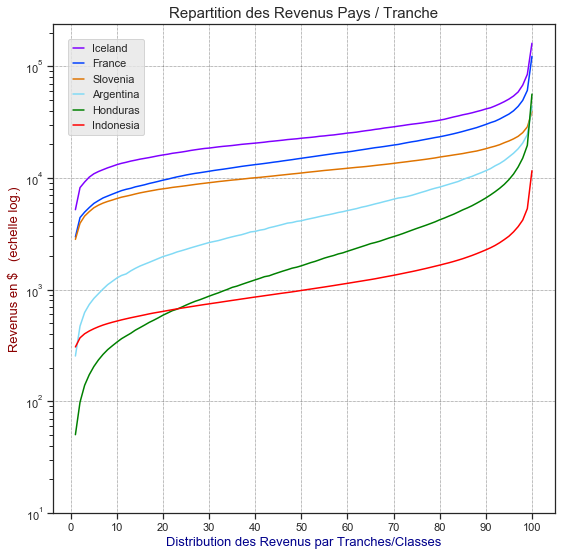

In [33]:
# lib_pays = ["Iceland", "France", "Slovenia", "Argentina", "Honduras", "Indonesia"]
# cod_pays = ["ISL", "FRA", "SVN", "ARG", "HND", "IDN"]
col_pays = ["#8000FF", "#0040FF", "#DF7401", "#81DAF5", "green", "red"]

df_lorenz = gen.reset_index()
plt.rcParams['legend.handlelength'] = 1  #  Permet d'ajouter le trait de couleur dans la légende
sns.set_style("ticks")
# sns.set() 
fig, ax = plt.subplots(figsize=[9,9])
plt.title("Repartition des Revenus Pays / Tranche", fontsize=15, y=1)

i = 0
for pays in cod_pays:
    yx = df_lorenz[df_lorenz['country_code'] == pays].groupby('quantile').mean()['income']
    plt.plot(yx, color=col_pays[i])
    i = i + 1
    
plt.xlabel("Distribution des Revenus par Tranches/Classes", color="darkblue", size=13) 
plt.ylabel("Revenus en $   (echelle log.)", color='darkred', size=13, rotation=90)     
# ax.yaxis.grid(linestyle='dotted')
ax.grid(color="black", linestyle=':', linewidth=0.5)
ax.legend((lib_pays), loc="upper left", bbox_to_anchor=(0.02, 0.98), facecolor="#E6E6E6")
ax.set_yscale('log')
ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
ax.set_yticks([10, 100, 1000, 10000, 100000])
plt.savefig('OUTFILES/M2-Repartition_revenus_selection_pays.png', dpi=100, bbox_inches='tight')

plt.show()

### <font color="darkblue">Courbe de Lorenz pour chaque pays :</font>

- Chargement des valeurs "income" du dataframe dans une variable par pays que l'on "TRIE" par ordre croissant !!!

In [53]:
def func_lorenz_graph(X, couleur):

    # Récupérer le pays
    pays = X.index.unique().values[0]
    lorenz = np.cumsum(X) / X.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    fig, ax = plt.subplots(figsize=[7,7])
    ## COURBE DE LORENZ
    plt.plot(np.linspace(0,1,len(lorenz)),lorenz,drawstyle='steps-post', color=couleur)
    plt.grid(color="black", linestyle=':', linewidth=0.5)
    # Titre Graphe
    titre_lorenz = "Courbe de Lorenz - Income 2008 - " + str(pays)
    plt.title(titre_lorenz, fontsize=15, color = couleur, y=1.05)
    # Libellé Abscisse (x)
    plt.xticks(size=13)
    plt.xlabel("Distribution des Classes Revenus (%)", color="black", size=14)              
    # Libellé Ordonnée (y)
    plt.yticks(size=13)
    plt.ylabel("Cumul Revenus (% richesses)", color='black', size=14, rotation=90)      
    # Analyses
    aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) 
    S = 0.5 - aire_ss_courbe 
    # Gini
    ind_gini = round(2*100*S, 2)
    txt_gini = "Indice Gini = " + str(ind_gini) + "%"
#     plt.figtext(0.45,0.5,txt_gini, fontsize=15, color = 'blue', rotation = 45)
    
    ## DROITE EGALITE (y=x)
    plt.plot([0,1], [0,1], color='black', label=pays)
    plt.legend(facecolor="#E6E6E6")
    
        
    txtfignam = "OUTFILES/M2-Courbe_Lorenz_"+pays+".png"
    plt.savefig(txtfignam, dpi=100, bbox_inches='tight')
    


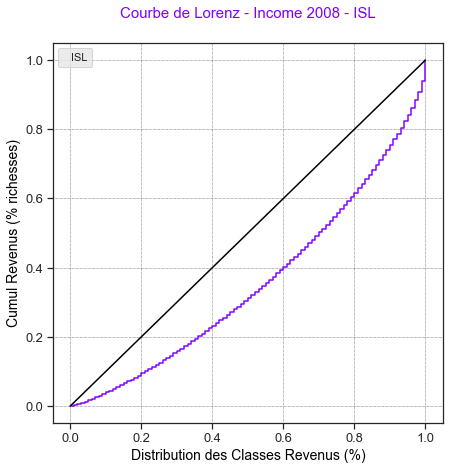

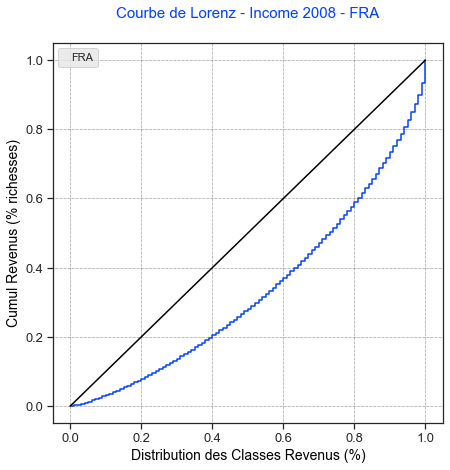

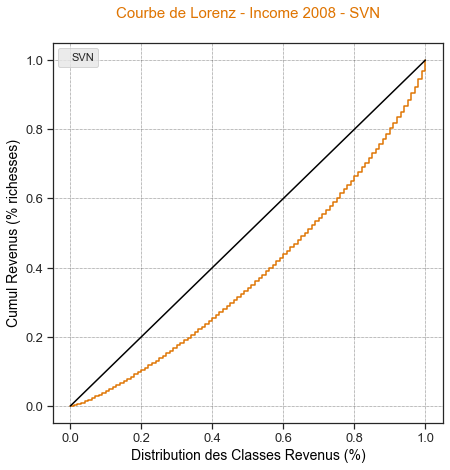

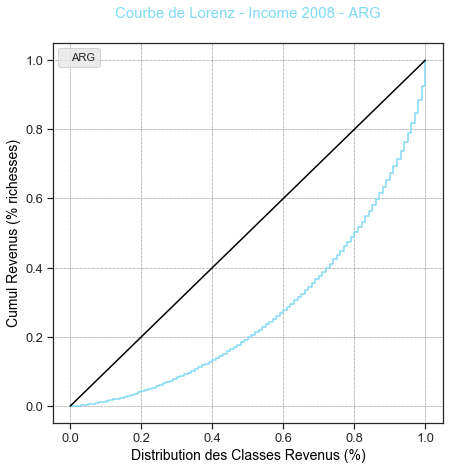

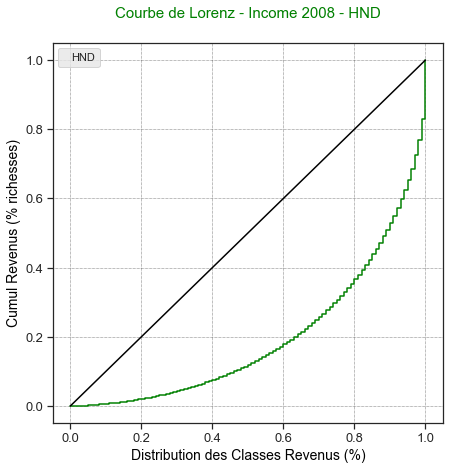

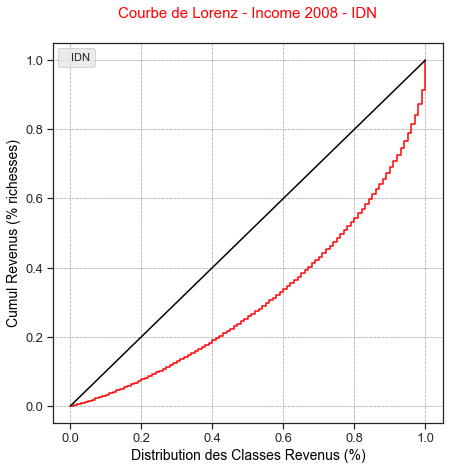

In [54]:
sns.set_style("ticks")
plt.rcParams['legend.handlelength'] = 0 
# Boucle sur liste des pays sélectionnés.
i = 0
for pays in cod_pays:
#     plt.subplot(int(len(cod_pays)/2), 2, i+1)
    lorenz = df_lorenz[df_lorenz['country_code'] == pays][['income', 'country_code']].copy().set_index('country_code')
    func_lorenz_graph(lorenz, col_pays[i])
    i = i + 1
    plt.show()

# plt.show()

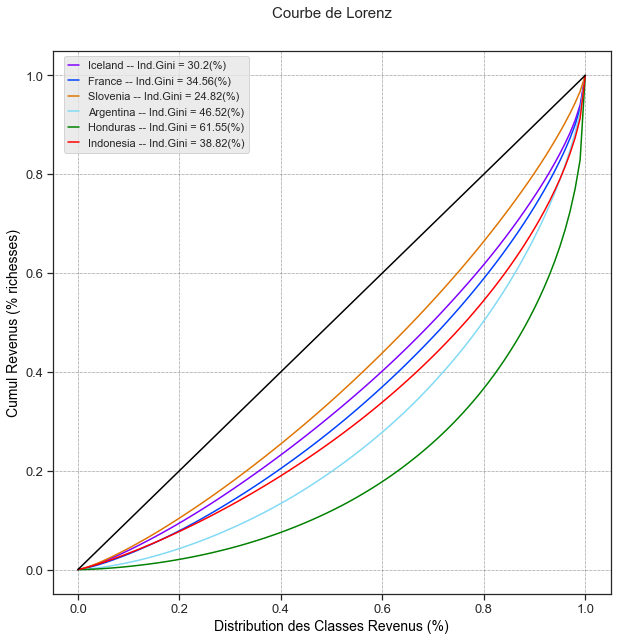

In [36]:
sns.set_style("ticks")
plt.rcParams['legend.handlelength'] = 1  #  Permet d'ajouter le trait de couleur dans la légende
    
fig, ax = plt.subplots(figsize=[10,10])

# Boucle sur liste des pays sélectionnés.
i = 0
calc_gini = [0] * len(cod_pays)
lgd_gini = [""] * len(cod_pays)
for pays in cod_pays:
    X = df_lorenz[df_lorenz['country_code'] == pays][['income', 'country_code']].copy().set_index('country_code')
    lorenz = np.cumsum(X) / X.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
    ## Courbe de Lorenz
    plt.plot(np.linspace(0,1,len(lorenz)),lorenz, color=col_pays[i]) # drawstyle='steps-post',
    # Analyses
    aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) 
    S = 0.5 - aire_ss_courbe 
    # Gini
    calc_gini[i] = round(2*100*S, 2)
    lgd_gini[i] = lib_pays[i] + " -- Ind.Gini = " + str(calc_gini[i]) + "(%)"
    i = i + 1

# TITRE GRAPHE 
plt.title("Courbe de Lorenz", fontsize=15, y=1.05)
# Libellé Abscisse (x)
plt.xticks(size=13)
plt.xlabel("Distribution des Classes Revenus (%)", color="black", size=14)              
# Libellé Ordonnée (y)
plt.yticks(size=13)
plt.ylabel("Cumul Revenus (% richesses)", color='black', size=14, rotation=90)      
ax.legend((lgd_gini), loc="upper left", bbox_to_anchor=(0.01, 1), facecolor="#E6E6E6")    
## Ligne d'égalité
ax.plot([0,1], [0,1], color='black', label=pays)
ax.grid(color="black", linestyle=':', linewidth=0.5)

plt.savefig("OUTFILES/M2-Courbe_Lorenz_Selection_Pays", dpi=100, bbox_inches='tight')    
plt.show()
plt.close()

### <font color="darkblue">Graphique Evolution Gini au fil des ans</font>

- On reprend un dataframe constitué précédemment et contenant l'évolution des indices de Gini entre 2004 et 2011  
- On ne conserve <b>que les pays</b>  possedant des indices renseignés sur <b>toutes les années</b>.

In [37]:
gini_evo.dropna(how="any")
# Renommer certaines colonnes
gini_evo.rename(columns=
           {'gini04':'2004', 'gini05':'2005', 'gini06':'2006', 'gini07':'2007',
            'gini08':'2008', 'gini09':'2009', 'gini10':'2010', 'gini11':'2011',
           }, inplace=True)
gini_evo

,2004,2005,2006,2007,2008,2009,2010,2011
country_code,,,,,,,,
ALB,nan,30.600,nan,nan,30.000,nan,nan,nan
ARG,48.300,47.700,46.600,46.300,44.500,43.900,43.000,42.300
ARM,37.500,36.000,29.700,31.200,29.200,28.000,30.000,29.400
AUT,29.800,28.700,29.600,30.600,30.400,31.500,30.300,30.800
AZE,26.600,26.600,nan,nan,nan,nan,nan,nan
BEL,30.500,29.300,28.100,29.200,28.400,28.500,28.400,28.100
BFA,nan,nan,nan,nan,nan,39.800,nan,nan
BGD,nan,33.200,nan,nan,nan,nan,32.100,nan
BGR,nan,nan,35.700,36.100,33.600,33.800,35.700,34.300


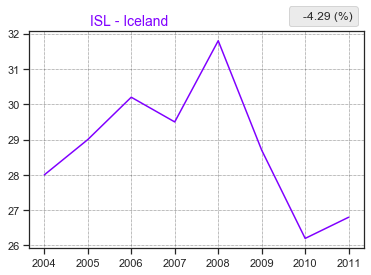

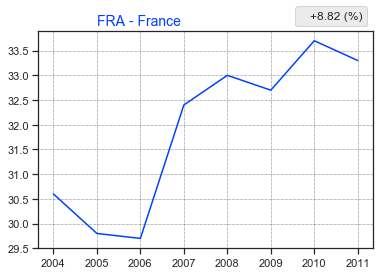

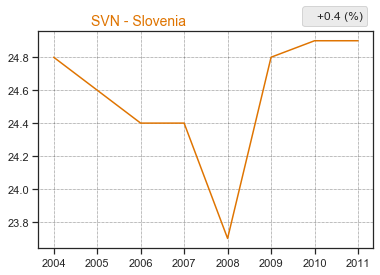

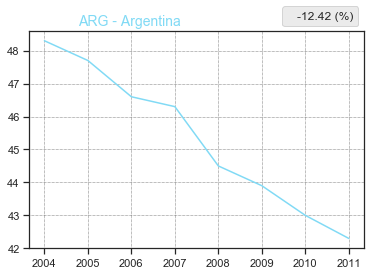

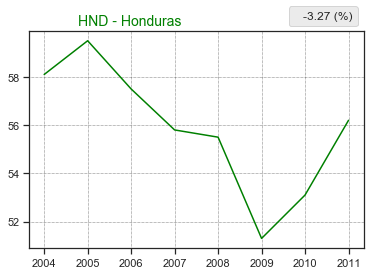

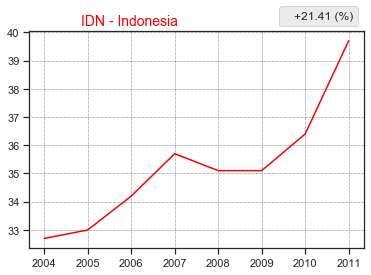

In [38]:
plt.rcParams['legend.handlelength'] = 0  #  Permet de retirer le trait de couleur dans la légende
sns.set_style("ticks")
i = 0
for pays in cod_pays:
    fig, ax = plt.subplots(figsize=[6,4])
    ax.grid(color="black", linestyle=':', linewidth=0.5)
    y = gini_evo.columns
    x = gini_evo[gini_evo.index == pays].values[0]
    plt.plot(y, x, color=col_pays[i])
    # Gestion de la "Légende" avec % evolution et augmentation en valeur
    gini_end = gini_evo[gini_evo.index == pays].values[0][7]
    gini_start = gini_evo[gini_evo.index == pays].values[0][0]
    pct_evo = round((gini_end/gini_start -1)*100, 2)
    if pct_evo>0:
        pct_evo=("+{}".format(pct_evo))
    txtlgd = str(pct_evo) + " (%)"
    ax.legend([txtlgd], fontsize=12, loc="upper right", bbox_to_anchor=(1, 1.14), facecolor="#E6E6E6")
    
    titre_graph = pays + " - " + lib_pays[i]
    plt.title(titre_graph, x=0.3, size=14, color=col_pays[i])
    txtfignam = "OUTFILES/M2-Evolution_Gini_2004_2011"+pays+".png"
    plt.savefig(txtfignam, dpi=100, bbox_inches='tight')
    i = i + 1
    plt.show()

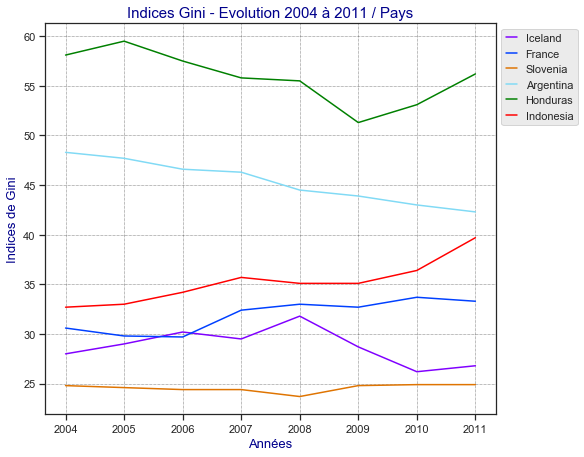

In [39]:
plt.rcParams['legend.handlelength'] = 1  #  Permet d'ajouter le trait de couleur dans la légende
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=[8,6])

i=0
for pays in cod_pays:
    plt.plot(gini_evo.columns, gini_evo[gini_evo.index == pays].values[0], color=col_pays[i])
    i = i + 1
    
ax.grid(color="black", linestyle=':', linewidth=0.5)
ax.legend((lib_pays), loc="upper left", bbox_to_anchor=(1, 1), facecolor="#E6E6E6")
plt.tight_layout()
plt.title("Indices Gini - Evolution 2004 à 2011 / Pays", fontsize=15, color = "darkblue", y=1.05)
plt.xlabel("Années", color = "darkblue", size=13) 
plt.ylabel("Indices de Gini", color = "darkblue", size=13, rotation=90)     
plt.savefig("OUTFILES/M2-Evolution_Gini_2004_2011_selection_pays.png", dpi=100, bbox_inches='tight')
plt.show()

### <font color="darkblue">Classemnent des pays par indice de Gini. </font>

- Moyenne de l'indice de Gini, tous pays confondus (entre 2004 et 2011)  
- 5 pays ayant l'indice de Gini le plus élevé
- 5 pays ayant l'indice de Gini le plus faible  
- Position de la France dans ce classement


#### <font color="darkblue">Indide Gini Moyen = 38.95</font>

In [40]:
pd.options.display.max_rows=200
round(gini_moy.gini.mean(),2)

38.95

#### <font color="darkblue">5 pays ayant l'indice de Gini le plus élevé</font>

- AFRIQUE DU SUD
- NAMIBIE
- BOTSWANA
- REPUBLIQUE CENTRAFRICAINE
- COMORES (ILES)

In [41]:
gini_moy.sort_values(by="gini", ascending=False).reset_index(drop=True).head()

,country_code,country_name,gini
0,ZAF,South Africa,63.733
1,NAM,Namibia,61.000
2,BWA,Botswana,60.500
3,CAF,Central African Republic,56.200
4,COM,Comoros,55.900


#### <font color="darkblue">5 pays ayant l'indice de Gini le plus faible</font>

- SLOVENIE
- DANEMARK
- REPUBLIQUE TCHEQUE
- AZERBAÏDJAN
- SLOVAQUIE

In [42]:
gini_moy = gini_moy.sort_values(by="gini").reset_index(drop=True)
gini_moy.head(5)

,country_code,country_name,gini
0,SVN,Slovenia,24.563
1,DNK,Denmark,26.075
2,CZE,Czech Republic,26.575
3,AZE,Azerbaijan,26.600
4,SVK,Slovak Republic,26.738


#### <font color="darkblue">Position de la France dans ce classement</font>

- FRANCE :  <b>34ème</b> dans le Classement des Pays sur Indice de Gini le plus faible

In [92]:
# L'index commençant à 0, la France se trouve donc en 34ème position (33+1) de cette liste de 153 pays
gini_moy[gini_moy.index > 25].sort_values(by="gini").head(15)

,rank,country_code,country_name,gini
26,27,LUX,Luxembourg,31.175
27,28,CYP,Cyprus,31.312
28,29,ARM,Armenia,31.375
29,30,EGY,"Egypt, Arab Rep.",31.467
30,31,ETH,Ethiopia,31.500
31,32,PAK,Pakistan,31.500
32,33,LBN,Lebanon,31.800
33,34,FRA,France,31.900
34,35,KOR,"Korea, Rep.",32.000
35,36,JPN,Japan,32.100


<hr style="height: 3px; color: #839D2D; width: 100%; ">

##  <font color='#61210B'><u>M3 - Préparation Données pour Mission 3</u></font>
Pour le Calcul probabilités conditionnelles, régressions et ANOVA futures



<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Données "mobilité intergénérationnelle" de la Banque Mondiale : Dataframe "gdim"</font>  
- Période de couverture des Naissances : <b>1940-1989</b>  
- Années d'etude : <b>1991-2016</b>  
- Pourcentage de la population couverte : <b>96(%)</b> 

<u>Définition des Variables sélectionnées</u> :  

    - wbcode      : World Bank economy code
    - countryname : Economic Name
    - cohort      : 10-year cohorts  (décennies)
    - year        : Year
    - incgroup4   : Income groups (4 categories) as of July 1, 2016
    - IGEincome   : Relative IGM in income (InterGenerational Mobility)
    - parent      : Mothers/Fathers/Average/Max
    - child       : Sons/Daughters/All
    - obs         : Observations in particular cell
    - MEANp       : Mean of parents' years of education
    - MEANc       : Mean of children's years of education
    - GINIp       : Gini index of parents' years of education
    - GINIc       : Gini index of children's years of education

In [44]:
gdim = pd.read_excel("DATA/gdim.xlsx", sheet_name='data')
print("Dimension Tableau : ", gdim.shape)
print("Colonnes :", gdim.columns)

Dimension Tableau :  (6504, 66)
Colonnes : Index(['countryname', 'wbcode', 'iso3', 'region', 'incgroup2', 'incgroup4',
       'fragile', 'survey', 'year', 'status', 'cohort', 'parent', 'child',
       'obs', 'P1', 'P2', 'P3', 'P4', 'P5', 'C1', 'C2', 'C3', 'C4', 'C5',
       'MEANp', 'MEANc', 'SDp', 'SDc', 'GINIp', 'GINIc', 'IGP', 'NL1', 'NL2',
       'COR', 'MAcatM', 'MAcatC1', 'Q4_IGpri', 'BHQ1', 'BHQ2', 'BHQ3', 'BHQ4',
       'Q4BH', 'Q4child', 'Delta50', 'Asher_Q4_IGpri', 'ThreeGen_obs',
       'ThreeGen_IGPp1', 'ThreeGen_IGPg1', 'ThreeGen_IGPgsd', 'All2125_MEANp',
       'All2125_MEANc', 'All2125_IGP', 'All2125_MAcatC1', 'Cores2125_MEANp',
       'Cores2125_MEANc', 'Cores2125_IGP', 'Cores2125_MAcatC1',
       'Shortfall0611_obs', 'Shortfall0611_IGP', 'Shortfall1217_obs',
       'Shortfall1217_IGP', 'IGEincome', 'S1', 'S2', 'S3', 'MLD_psu'],
      dtype='object')


<font color='blue'><i><b>Constitution d'un dataframe en supprimant les doublons</i></b></font>  
Compter le nombre de pays et calculer le (%) de couverture mondiale

In [45]:
df = gdim[["iso3", "countryname", "region", "IGEincome"]].copy().drop_duplicates()
df = df.groupby(["iso3", "countryname", "region"])[["IGEincome"]].mean().reset_index()
df.rename(columns=
           {'iso3':'country_code', 
            'countryname':'country_name'
           },
           inplace=True)
print("Dimension Tableau : ", df.shape)
df.info()
df.head()

Dimension Tableau :  (150, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
country_code    150 non-null object
country_name    150 non-null object
region          150 non-null object
IGEincome       75 non-null float64
dtypes: float64(1), object(3)
memory usage: 4.8+ KB


,country_code,country_name,region,IGEincome
0,AFG,Afghanistan,South Asia,nan
1,AGO,Angola,Sub-Saharan Africa,nan
2,ALB,Albania,Europe & Central Asia,0.816
3,ARG,Argentina,Latin America & Caribbean,nan
4,ARM,Armenia,Europe & Central Asia,nan


#### <font color='blue'><i>Taux de couverture du dataframe pour les pays de "df" ayant une valeur IGEincome :</font>

De plus, dans le prolongement du postulat de l'étude, je ne conserve que les populations de l'année 2008

In [46]:
pop = pop[pop['year'] == 2008].reset_index(drop=True)
popdf = pd.merge(df.dropna(), pop, on=['country_code'], how='inner').groupby('country_code').mean().sum()['population']
popdf

5199047246.0

In [47]:
taux_couv_IGEincome = 100*popdf / pop_monde_2008
print(round(taux_couv_IGEincome, 3), "(%)")

76.933 (%)


#### <font color='blue'><i>Approximation :</i></font>  
  
<pre>
<b>o</b> 1ère Etude (income, ind_gini) : Population couverte par l'analyse (114 pays) = <b>91.26(%)</b>
<b>o</b> 2ème Etude (coeff.elasticité) : Population couverte par l'analyse (74 pays)  = <b>76.93(%)</b>

</pre>

<font color='blue'>Je vais utiliser la moyenne du coefficient de mobilité intergénétationnelle de la region du pays pour combler les données manquantes de ce pays.</font>

In [48]:
df_byreg = df.groupby(["region"])[["IGEincome"]].mean().reset_index()
df_byreg

,region,IGEincome
0,East Asia & Pacific,0.504
1,Europe & Central Asia,0.466
2,High income,0.346
3,Latin America & Caribbean,0.897
4,Middle East & North Africa,0.817
5,South Asia,0.505
6,Sub-Saharan Africa,0.665


In [49]:
# IGE_mean = round(df.mean()['IGEincome'], 3)
# Remplissage des IGEincome "Nan", par la valeur moyenne précédemment calculée
# df.fillna(IGE_mean, inplace=True)
# IGE_mean

upd0 = df.loc[df['region'] == "East Asia & Pacific",'IGEincome'].mean()
upd1 = df.loc[df['region'] == "Europe & Central Asia",'IGEincome'].mean()
upd2 = df.loc[df['region'] == "High income",'IGEincome'].mean()
upd3 = df.loc[df['region'] == "Latin America & Caribbean",'IGEincome'].mean()
upd4 = df.loc[df['region'] == "Middle East & North Africa",'IGEincome'].mean()
upd5 = df.loc[df['region'] == "South Asia",'IGEincome'].mean()
upd6 = df.loc[df['region'] == "Sub-Saharan Africa",'IGEincome'].mean()

df.loc[df['region'] == "East Asia & Pacific",'IGEincome'] = df.loc[df['region'] == "East Asia & Pacific",'IGEincome'].fillna(upd0)
df.loc[df['region'] == "Europe & Central Asia",'IGEincome'] = df.loc[df['region'] == "Europe & Central Asia",'IGEincome'].fillna(upd1)
df.loc[df['region'] == "High income",'IGEincome'] = df.loc[df['region'] == "High income",'IGEincome'].fillna(upd2)
df.loc[df['region'] == "Latin America & Caribbean",'IGEincome'] = df.loc[df['region'] == "Latin America & Caribbean",'IGEincome'].fillna(upd3)
df.loc[df['region'] == "Middle East & North Africa",'IGEincome'] = df.loc[df['region'] == "Middle East & North Africa",'IGEincome'].fillna(upd4)
df.loc[df['region'] == "South Asia",'IGEincome'] = df.loc[df['region'] == "South Asia",'IGEincome'].fillna(upd5)
df.loc[df['region'] == "Sub-Saharan Africa",'IGEincome'] = df.loc[df['region'] == "Sub-Saharan Africa",'IGEincome'].fillna(upd6)

<hr style="height: 1px; color: #E0ECF8; width: 100%; ">

### <font color="darkblue"> Fusion Données "GDIM" corrigées avec Données etude précédente "gen"</font>  

Dataframe Final :  <b>pj7</b>

In [50]:
pj7 = pd.merge(gen, df[['country_code', 'IGEincome']], on=['country_code'], how='inner').drop_duplicates()
# Renommage des colonnes & Suppression de colonnes plus utiles
pj7 = pj7.rename(columns={'IGEincome':'pj', "quantile":"c_i_child"}).drop(columns=['country_name', 'pop'])
pj7 = pj7[['country_code', 'c_i_child', 'pj', 'income', 'gini', 'gdpppp']]
pj7.info()
pj7.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11200 entries, 0 to 11199
Data columns (total 6 columns):
country_code    11200 non-null object
c_i_child       11200 non-null int64
pj              11200 non-null float64
income          11200 non-null float64
gini            11200 non-null float64
gdpppp          11200 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 612.5+ KB


,country_code,c_i_child,pj,income,gini,gdpppp
0,ALB,1,0.816,728.898,30.300,"7,297.000"
1,ALB,2,0.816,916.662,30.300,"7,297.000"
2,ALB,3,0.816,"1,010.916",30.300,"7,297.000"
3,ALB,4,0.816,"1,086.908",30.300,"7,297.000"
4,ALB,5,0.816,"1,132.700",30.300,"7,297.000"


In [51]:
req1 = ''' 
Select distinct a.country_code, b.country_code as pays_igm
From gen a Left Join df b on a.country_code=b.country_code
Where b.country_code is null
'''
df1 = execsql(req1)
df1

,country_code,pays_igm
0,SYR,None
1,XKX,None


On perd 2 pays supplémentaires lors de la fusion.  
En effet, le Kosovo(KSV) et la Syrie(SYR) n'ont pas été trouvés dans les données de mobilité intergénérationelle

<hr style="height: 3px; color: #839D2D; width: 100%; ">

###  <font color='#61210B'><u>Export des Dataframes</u></font> :
#### Dans fichiers csv - Pour Missions 3 & 4

In [52]:
# Export dans un fichier externe
pj7.to_excel('OUTFILES/pj7_m3.xlsx', sheet_name='pj7_m3')
pj7.to_csv('OUTFILES/pj7_m3.csv', sep=',', encoding='utf-8', index=False)
duree = round(time.time() - start_time, 5)
print("Durée du traitement :", "%s seconds" % duree)


Durée du traitement : 14.651 seconds
